# Project 6: Self-supervised Neural Network Learning

## I: Load date

In [440]:
!pip install torch torchvision torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

In [441]:
# Load the three datasets as specified in the question
labeled_data = pd.read_csv('Task2C_labeled.csv')
unlabeled_data = pd.read_csv('Task2C_unlabeled.csv') 
test_data = pd.read_csv('Task2C_test.csv')

In [442]:
print(f"Labeled data shape: {labeled_data.shape}")
print(f"Unlabeled data shape: {unlabeled_data.shape}")
print(f"Test data shape: {test_data.shape}")

Labeled data shape: (50, 785)
Unlabeled data shape: (1500, 784)
Test data shape: (500, 785)


In [443]:
# Prepare data for the autoencoder and neural network training
# According to the assignment:
# - Use both labeled and unlabeled data to train autoencoder
# - Use only labeled data to train classifiers
# - Evaluate on test data

# Extract features and labels from labeled data
# FIRST column is label, remaining columns are features
y_labeled = labeled_data.iloc[:, 0].values   # First column (labels)
X_labeled = labeled_data.iloc[:, 1:].values  # All columns from second onwards (features)

# Extract features from unlabeled data (no labels available)
X_unlabeled = unlabeled_data.values

# Extract features and labels from test data
# FIRST column is label, remaining columns are features
y_test = test_data.iloc[:, 0].values   # First column (labels)
X_test = test_data.iloc[:, 1:].values  # All columns from second onwards (features)

# Combine labeled and unlabeled features for autoencoder training
X_autoencoder = np.vstack([X_labeled, X_unlabeled]) # Use np.vstack() to vertically stack X_labeled and X_unlabeled arrays

# Standardize all features using the same scaler to ensure consistency
scaler = StandardScaler() # Create a StandardScaler object to normalize features to mean=0, std=1

# Fit the scaler on labeled data and transform it simultaneously
# fit(): compute mean and std from X_labeled
# transform(): apply standardization using computed parameters
X_labeled_scaled = scaler.fit_transform(X_labeled)

# Transform combined data using the same scaler parameters fitted on labeled data
X_autoencoder_scaled = scaler.transform(X_autoencoder)
# Transform test data using the same scaler parameters
X_test_scaled = scaler.transform(X_test)

print("Data preparation completed successfully!")
print(f"Features for autoencoder training: {X_autoencoder_scaled.shape}")
print(f"Features for classifier training: {X_labeled_scaled.shape}")
print(f"Features for testing: {X_test_scaled.shape}")
print(f"Input dimension for Autoencoder: {X_autoencoder_scaled.shape[1]}")

Data preparation completed successfully!
Features for autoencoder training: (1550, 784)
Features for classifier training: (50, 784)
Features for testing: (500, 784)
Input dimension for Autoencoder: 784


## II: Train autoencoder with different hidden layer sizes

In [515]:
# Set random seeds for reproducible results
torch.manual_seed(42)
np.random.seed(42)

# Define the range of hidden layer sizes as specified
hidden_sizes = list(range(20, 221, 40))  # 20, 60, 100, 140, 180, 220
print(f"Hidden layer sizes to test: {hidden_sizes}")

Hidden layer sizes to test: [20, 60, 100, 140, 180, 220]


In [445]:
# Define Autoencoder class using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        """
        Simple autoencoder with one hidden layer
        input_dim: number of input features
        hidden_dim: number of neurons in hidden layer
        """
        super(Autoencoder, self).__init__()
        
        # Encoder: input -> hidden layer
        self.encoder = nn.Linear(input_dim, hidden_dim) # Create linear layer that maps input features to hidden representation
        
        # Decoder: hidden layer -> output (same size as input)
        self.decoder = nn.Linear(hidden_dim, input_dim) # Create linear layer that reconstructs input from hidden representation
        
        # Activation function
        self.activation = nn.ReLU() # Use ReLU activation function for non-linearity
    
    def forward(self, x):
        """
        Forward pass through the autoencoder
        """
        # Encode: input -> hidden representation
        encoded = self.activation(self.encoder(x)) # Apply encoder and activation to get compressed representation
        
        # Decode: hidden representation -> reconstructed input
        decoded = self.decoder(encoded) # Apply decoder to reconstruct original input from hidden representation
        
        return decoded # Return the reconstructed input
    
    def encode(self, x):
        """
        Get the encoded representation (hidden layer output)
        This will be used later for feature extraction
        """
        with torch.no_grad():
            # Disable gradient computation for inference
            encoded = self.activation(self.encoder(x))

        # Return the hidden layer features for feature extraction
        return encoded

In [446]:
# Training function for autoencoder
def train_autoencoder(model, data, epochs=100, learning_rate=0.001):
    """
    Train the autoencoder model
    model: the autoencoder model
    data: training data (numpy array)
    epochs: number of training epochs
    learning_rate: learning rate for optimizer
    """
    # Convert data to PyTorch tensor
    data_tensor = torch.FloatTensor(data)
    
    # Define loss function (Mean Squared Error for reconstruction)
    criterion = nn.MSELoss()
    
    # Define optimizer (Adam optimizer)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        # Forward pass: get reconstructed data
        reconstructed = model(data_tensor)# Pass data through autoencoder to get reconstruction
        
        # Calculate reconstruction loss
        loss = criterion(reconstructed, data_tensor)  # Compute MSE between original and reconstructed data
        
        # Backward pass: compute gradients
        optimizer.zero_grad()# Clear gradients from previous iteration
        loss.backward() # Compute gradients through backpropagation
        
        # Update weights
        optimizer.step() # Apply computed gradients to update model parameters
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    return model

In [447]:
# Dictionary to store trained models with different hidden sizes for later use
trained_autoencoders = {}

In [448]:
# Train autoencoder for each hidden layer size
print("\nTraining autoencoders with different hidden layer sizes...")
print("=" * 60)

for hidden_size in hidden_sizes:
    # Iterate through each hidden layer size
    
    print(f"\nTraining autoencoder with {hidden_size} hidden neurons:")
    print("-" * 50)
    
    
    # Instantiate autoencoder with current hidden layer size
    autoencoder = Autoencoder(input_dim, hidden_size) 
    
    # Train the model on scaled data for 100 epochs
    trained_model = train_autoencoder(autoencoder, X_autoencoder_scaled, epochs=100)
    
    # Save trained model in dictionary with hidden size as key
    trained_autoencoders[hidden_size] = trained_model
    
    print(f"Autoencoder with {hidden_size} hidden neurons trained successfully!")

print("\n" + "=" * 60)
print("All autoencoders trained successfully!")
print(f"Trained models stored for hidden sizes: {list(trained_autoencoders.keys())}")


Training autoencoders with different hidden layer sizes...

Training autoencoder with 20 hidden neurons:
--------------------------------------------------
Epoch [20/100], Loss: 34.447723
Epoch [40/100], Loss: 33.111141
Epoch [60/100], Loss: 29.146603
Epoch [80/100], Loss: 26.157701
Epoch [100/100], Loss: 24.165165
Autoencoder with 20 hidden neurons trained successfully!

Training autoencoder with 60 hidden neurons:
--------------------------------------------------
Epoch [20/100], Loss: 32.003014
Epoch [40/100], Loss: 24.740686
Epoch [60/100], Loss: 18.844101
Epoch [80/100], Loss: 14.237258
Epoch [100/100], Loss: 10.848261
Autoencoder with 60 hidden neurons trained successfully!

Training autoencoder with 100 hidden neurons:
--------------------------------------------------
Epoch [20/100], Loss: 29.024204
Epoch [40/100], Loss: 20.076479
Epoch [60/100], Loss: 13.297355
Epoch [80/100], Loss: 8.912227
Epoch [100/100], Loss: 6.286467
Autoencoder with 100 hidden neurons trained successfu

## III: Calculate reconstruction errors and plot results

In [449]:
# Calculate average Euclidean distances between input and output
def calculate_reconstruction_error(model, data):
    """
    Calculate reconstruction error as average Euclidean distance
    model: trained autoencoder model
    data: input data (numpy array)
    Returns: average Euclidean distance between input and reconstructed output
    """
    # Set model to evaluation mode
    model.eval()
    
    # Convert data to PyTorch tensor
    data_tensor = torch.FloatTensor(data)
    
    with torch.no_grad():
        # Get reconstructed output from autoencoder
        reconstructed = model(data_tensor)
        
        # Calculate Euclidean distance for each sample
        # torch.norm calculates L2 norm (Euclidean distance) along dimension 1
        euclidean_distances = torch.norm(data_tensor - reconstructed, dim=1)
        
        # Calculate average Euclidean distance
        avg_euclidean_distance = torch.mean(euclidean_distances).item()
    
    return avg_euclidean_distance

In [450]:
# Dictionary to store reconstruction errors for each hidden layer size
reconstruction_errors = {}

In [451]:
# Calculate reconstruction error for each trained autoencoder
for hidden_size in hidden_sizes:
    print(f"Calculating reconstruction error for {hidden_size} hidden neurons...")
    
    # Get the trained model
    model = trained_autoencoders[hidden_size]
    
    # Calculate reconstruction error using the autoencoder training data
    error = calculate_reconstruction_error(model, X_autoencoder_scaled)
    
    # Store the result
    reconstruction_errors[hidden_size] = error
    
    print(f"Reconstruction error: {error:.6f}")

print("\n" + "=" * 60)
print("Reconstruction Error Results:")
print("-" * 30)
for hidden_size, error in reconstruction_errors.items():
    print(f"Hidden units: {hidden_size:3d} | Reconstruction error: {error:.6f}")

Calculating reconstruction error for 20 hidden neurons...
Reconstruction error: 76.575935
Calculating reconstruction error for 60 hidden neurons...
Reconstruction error: 57.863438
Calculating reconstruction error for 100 hidden neurons...
Reconstruction error: 47.570976
Calculating reconstruction error for 140 hidden neurons...
Reconstruction error: 40.964081
Calculating reconstruction error for 180 hidden neurons...
Reconstruction error: 37.105999
Calculating reconstruction error for 220 hidden neurons...
Reconstruction error: 33.586815

Reconstruction Error Results:
------------------------------
Hidden units:  20 | Reconstruction error: 76.575935
Hidden units:  60 | Reconstruction error: 57.863438
Hidden units: 100 | Reconstruction error: 47.570976
Hidden units: 140 | Reconstruction error: 40.964081
Hidden units: 180 | Reconstruction error: 37.105999
Hidden units: 220 | Reconstruction error: 33.586815


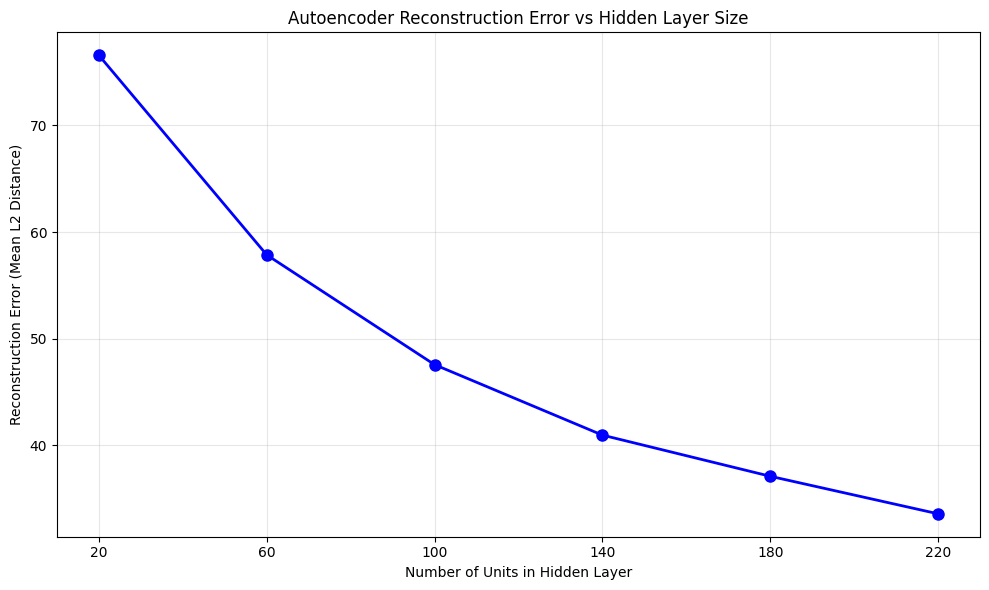


Lowest reconstruction error: 33.586815
Highest reconstruction error: 76.575935


In [452]:
# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(list(reconstruction_errors.keys()), 
         list(reconstruction_errors.values()), 
         'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Units in Hidden Layer')
plt.ylabel('Reconstruction Error (Mean L2 Distance)')
plt.title('Autoencoder Reconstruction Error vs Hidden Layer Size')
plt.grid(True, alpha=0.3)
plt.xticks(hidden_sizes)  # Show all hidden sizes on x-axis
plt.tight_layout()
plt.show()

print(f"\nLowest reconstruction error: {min(reconstruction_errors.values()):.6f}")
print(f"Highest reconstruction error: {max(reconstruction_errors.values()):.6f}")

# Explanation of Reconstruction Error Findings

Based on the reconstruction error plot, several important observations can be made:

## Observations

- **Decreasing Reconstruction Error with Larger Hidden Layers：**
As the number of hidden units increases from 20 to 220, the reconstruction error consistently decreases. This indicates that larger hidden layers enable the model to capture and reconstruct more complex patterns in the data.

- **Diminishing Returns:**
The error reduction becomes less significant after 140 hidden units. For example, the drop in error from 20 → 60 is much larger than from 180 → 220. This reflects diminishing returns as the model’s capacity increases.

## Explanation
**Why does reconstruction error decrease with more hidden units?**

- **Increased Representational Capacity:**
More hidden units provide the autoencoder with greater capacity to capture complex patterns and relationships in the input data. With more neurons, the model can learn richer internal representations.

- **Better Feature Learning:**
A larger hidden layer allows the autoencoder to learn more diverse and detailed features from the input data, leading to more accurate reconstructions.

## Conclusion

The results suggest that while increasing hidden layer size improves reconstruction quality, there is a trade-off between model complexity and performance gains. The optimal choice depends on the specific application requirements and computational constraints. For this dataset, hidden layer sizes around 140-220 units appear to provide good reconstruction quality with diminishing additional benefits from further increases.

## IV: Build 3-layer NN for classification using original attributes

In [486]:
# Define 3-layer Neural Network class using PyTorch
class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        3-layer Neural Network for classification
        input_dim: number of input features
        hidden_dim: number of neurons in hidden layer
        output_dim: number of output classes
        """
        super(ThreeLayerNN, self).__init__()
        
        # First layer: input -> hidden
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        
        # Second layer: hidden -> output
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        
        # Activation function
        self.activation = nn.ReLU()
    
    def forward(self, x):
        """Forward pass through the 3-layer network"""
        # Input -> Hidden layer with ReLU activation
        hidden = self.activation(self.layer1(x))
        
        # Hidden -> Output layer
        output = self.layer2(hidden)
        
        return output

# Training function for 3-layer neural network
def train_classifier(model, X_train, y_train, epochs=100, learning_rate=0.001):
    """
    Train the 3-layer neural network classifier
    """
    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.LongTensor(y_train)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_tensor) # Get model predictions (logits) for all training samples
        loss = criterion(outputs, y_tensor) # Calculate cross-entropy loss between predictions and true labels
        
        # Backward pass
        optimizer.zero_grad() # Clear gradients from previous iteration
        loss.backward()  # Compute gradients through backpropagation
        optimizer.step() # Update model parameters using computed gradients
    
    return model

# Function to calculate test error (corrected version)
def calculate_test_error(model, X_test, y_test):
    """
    Calculate test error using the classifier model
    model: trained neural network classifier
    X_test: test features
    y_test: test labels
    Returns: test error rate
    """
    # Set model to evaluation mode
    model.eval()
    
    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X_test)
    y_tensor = torch.LongTensor(y_test)
    
    with torch.no_grad():
        # Get predictions from classifier
        outputs = model(X_tensor)
        
        # Get predicted classes (index with highest probability)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate accuracy
        accuracy = (predicted == y_tensor).float().mean().item()
        
        # Test error = 1 - accuracy
        test_error = 1 - accuracy
    
    return test_error

# Get dimensions for the neural network
input_dim = X_labeled_scaled.shape[1] # Get number of input features from labeled data
output_dim = len(np.unique(y_labeled)) # Get number of unique classes from labeled data

print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")

# Hidden layer sizes to test (20, 60, 100, 140, 180, 220)
hidden_sizes = list(range(20, 221, 40))

# Dictionary to store results
nn_test_errors = {}
trained_classifiers = {}

print("\nTraining 3-layer Neural Networks...")
print("=" * 50)

# Train neural network for each hidden layer size
for hidden_size in hidden_sizes:
    print(f"Training with {hidden_size} hidden neurons...")
    
    # Create and train model
    nn_model = ThreeLayerNN(input_dim, hidden_size, output_dim)
    trained_model = train_classifier(nn_model, X_labeled_scaled, y_labeled)
    
    # Calculate test error
    test_error = calculate_test_error(trained_model, X_test_scaled, y_test)
    
    # Store results
    nn_test_errors[hidden_size] = test_error
    trained_classifiers[hidden_size] = trained_model
    
    print(f"Test error: {test_error:.6f}")

print("\n3-Layer Neural Network Results:")
print("-" * 40)
for hidden_size, error in nn_test_errors.items():
    print(f"Hidden units: {hidden_size:3d} | Test error: {error:.6f}")


Input dimension: 784
Output dimension: 10

Training 3-layer Neural Networks...
Training with 20 hidden neurons...
Test error: 0.484000
Training with 60 hidden neurons...
Test error: 0.442000
Training with 100 hidden neurons...
Test error: 0.428000
Training with 140 hidden neurons...
Test error: 0.452000
Training with 180 hidden neurons...
Test error: 0.424000
Training with 220 hidden neurons...
Test error: 0.448000

3-Layer Neural Network Results:
----------------------------------------
Hidden units:  20 | Test error: 0.484000
Hidden units:  60 | Test error: 0.442000
Hidden units: 100 | Test error: 0.428000
Hidden units: 140 | Test error: 0.452000
Hidden units: 180 | Test error: 0.424000
Hidden units: 220 | Test error: 0.448000


## V: Build augmented self-taught networks

In [494]:
def extract_autoencoder_features(autoencoder_model, data):
    """Extract features from the middle layer of trained autoencoder"""
    autoencoder_model.eval()
    data_tensor = torch.FloatTensor(data)
    # Use the encode method to get compressed representation from hidden layer
    encoded_features = autoencoder_model.encode(data_tensor) 
    return encoded_features.numpy()

# Dictionary to store test errors for augmented networks
augmented_test_errors = {}
trained_augmented_models = {}

print("\nBuilding Augmented Self-Taught Networks...")
print("=" * 50)

# For each autoencoder model, create augmented features and train classifier
for hidden_size in hidden_sizes:
    print(f"Model with {hidden_size} hidden neurons + {hidden_size} extra features...")
    
    # Step 1: Extract autoencoder features
    autoencoder = trained_autoencoders[hidden_size]
    autoencoder_features_train = extract_autoencoder_features(autoencoder, X_labeled_scaled)
    autoencoder_features_test = extract_autoencoder_features(autoencoder, X_test_scaled)
    
    # Step 2: Combine original features with autoencoder features
    X_augmented_train = np.hstack([X_labeled_scaled, autoencoder_features_train])
    X_augmented_test = np.hstack([X_test_scaled, autoencoder_features_test])
    
    # Step 3: Train new 3-layer NN with augmented features
    augmented_input_dim = X_augmented_train.shape[1]
    augmented_model = ThreeLayerNN(augmented_input_dim, hidden_size, output_dim)
    trained_augmented_model = train_classifier(augmented_model, X_augmented_train, y_labeled)
    
    # Calculate test error
    augmented_test_error = calculate_test_error(trained_augmented_model, X_augmented_test, y_test)
    
    # Store results
    augmented_test_errors[hidden_size] = augmented_test_error
    trained_augmented_models[hidden_size] = trained_augmented_model
    
    print(f"Test error: {augmented_test_error:.6f}")

print("\nAugmented Self-Taught Networks Results:")
print("-" * 50)
for hidden_size, error in augmented_test_errors.items():
    print(f"Hidden units: {hidden_size:3d} | Extra features: {hidden_size:3d} | Test error: {error:.6f}")



Building Augmented Self-Taught Networks...
Model with 20 hidden neurons + 20 extra features...
Test error: 0.450000
Model with 60 hidden neurons + 60 extra features...
Test error: 0.462000
Model with 100 hidden neurons + 100 extra features...
Test error: 0.460000
Model with 140 hidden neurons + 140 extra features...
Test error: 0.452000
Model with 180 hidden neurons + 180 extra features...
Test error: 0.470000
Model with 220 hidden neurons + 220 extra features...
Test error: 0.466000

Augmented Self-Taught Networks Results:
--------------------------------------------------
Hidden units:  20 | Extra features:  20 | Test error: 0.450000
Hidden units:  60 | Extra features:  60 | Test error: 0.462000
Hidden units: 100 | Extra features: 100 | Test error: 0.460000
Hidden units: 140 | Extra features: 140 | Test error: 0.452000
Hidden units: 180 | Extra features: 180 | Test error: 0.470000
Hidden units: 220 | Extra features: 220 | Test error: 0.466000


## VI: Plot error rates comparison

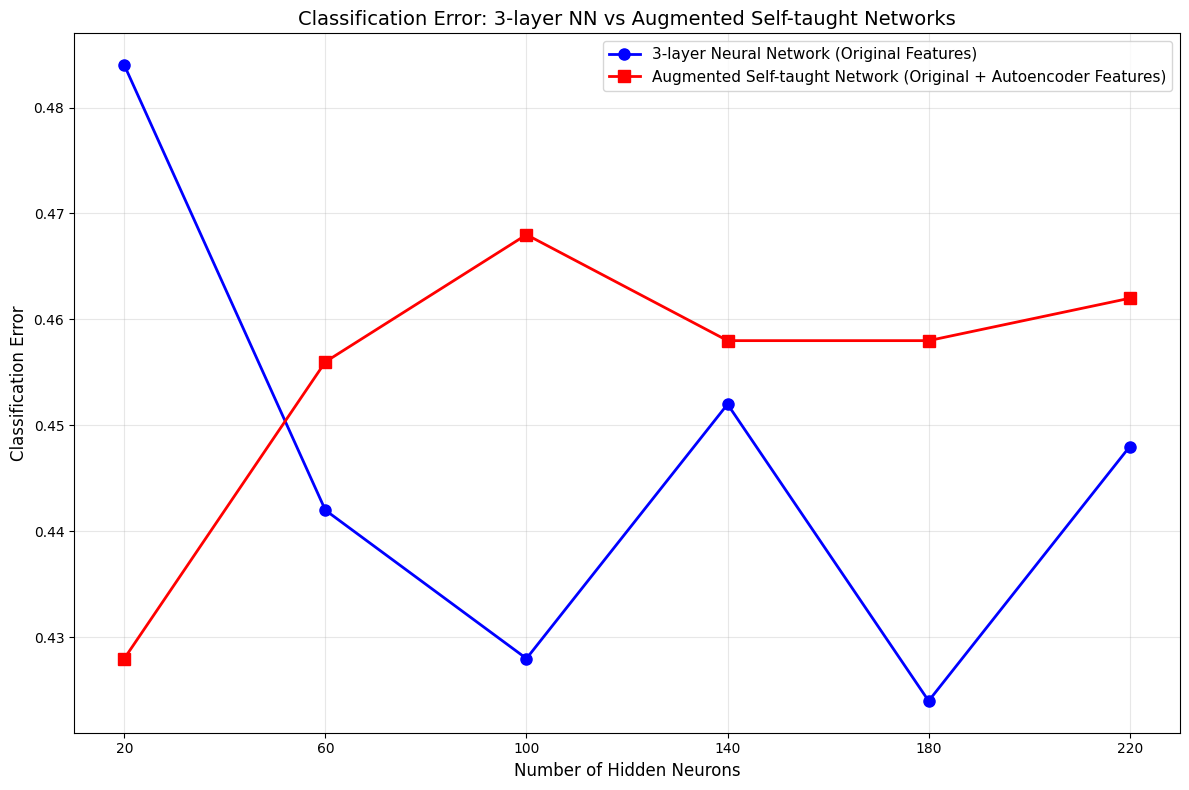


Comparison: Original vs Augmented Networks:
--------------------------------------------------
Hidden Units Original Error  Augmented Error  Improvement 
-------------------------------------------------------
20           0.484000        0.428000         0.056000    
60           0.442000        0.456000         -0.014000   
100          0.428000        0.468000         -0.040000   
140          0.452000        0.458000         -0.006000   
180          0.424000        0.458000         -0.034000   
220          0.448000        0.462000         -0.014000   

Summary:
Average original error: 0.446333
Average augmented error: 0.455000
Average improvement: -0.008667


In [490]:
# Extract data for plotting
hidden_neurons = sorted(hidden_sizes)
original_errors = [nn_test_errors[size] for size in hidden_neurons]
augmented_errors = [augmented_test_errors[size] for size in hidden_neurons]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(hidden_neurons, original_errors, 'b-o', linewidth=2, markersize=8, 
         label='3-layer Neural Network (Original Features)', markerfacecolor='blue')
plt.plot(hidden_neurons, augmented_errors, 'r-s', linewidth=2, markersize=8, 
         label='Augmented Self-taught Network (Original + Autoencoder Features)', markerfacecolor='red')

plt.xlabel('Number of Hidden Neurons', fontsize=12)
plt.ylabel('Classification Error', fontsize=12)
plt.title('Classification Error: 3-layer NN vs Augmented Self-taught Networks', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(hidden_neurons)

# Improve plot appearance
plt.tight_layout()
plt.show()

# Print numerical comparison
print("\nComparison: Original vs Augmented Networks:")
print("-" * 50)
print(f"{'Hidden Units':<12} {'Original Error':<15} {'Augmented Error':<16} {'Improvement':<12}")
print("-" * 55)

for hidden_size in hidden_neurons:
    original_error = nn_test_errors[hidden_size]
    augmented_error = augmented_test_errors[hidden_size]
    improvement = original_error - augmented_error
    print(f"{hidden_size:<12} {original_error:<15.6f} {augmented_error:<16.6f} {improvement:<12.6f}")

# Calculate and display summary statistics
avg_original = np.mean(original_errors)
avg_augmented = np.mean(augmented_errors)
avg_improvement = avg_original - avg_augmented

print(f"\nSummary:")
print(f"Average original error: {avg_original:.6f}")
print(f"Average augmented error: {avg_augmented:.6f}")
print(f"Average improvement: {avg_improvement:.6f}")


### Performance Comparison and Analysis

The plot above compares the classification error of two models:
- A 3-layer neural network trained on original features only
- An augmented self-taught network trained on both original and autoencoder features

#### Observations

- At **20 hidden units**, the augmented network significantly outperforms the original model, showing a notable reduction in classification error.
- As the number of hidden neurons increases, the performance of the **original network improves**, while the **augmented model plateaus** and even worsens slightly in some cases.
- In most configurations beyond 20 units, the **augmented model performs worse** than the original network.

#### Explanation

These results suggest that **autoencoder features can be helpful when the base model has limited capacity** (e.g., small hidden layer). In such cases, the encoded features provide useful abstractions that help the model generalize better.

However, as the number of hidden neurons increases, the 3-layer neural network becomes powerful enough to **learn complex patterns directly from the raw features**, reducing the benefit of additional encoded features. Furthermore, concatenating autoencoder features might introduce **redundant or noisy information**, which can lead to worse performance if not properly regularized.

The **average improvement** across all configurations is **slightly negative (-0.0087)**, suggesting that while self-taught learning can help in specific situations, it does not consistently outperform the standard network in this task.

#### Conclusion

- Augmented self-taught networks **can improve performance** when the model is small or underfitting.
- With larger networks, the benefit of autoencoder features diminishes or may even harm performance.
- The choice of whether to use self-taught learning should consider both **model capacity** and the **quality of unsupervised features**.
